## Luminosity comparison

In [1]:
# from import_data import HMXB_parameters_Kaper
# from import_data import HMXB_parameters
# from import_data import supergiant_stellar_parameters
# from import_data import falenga
# from functions import scientific_notation
# from functions import display_df
# from functions import decompose_spectral_type
# from import_data import stellar_params
# from import_data import photometric_params
# from import_data import BailerJones
from functions import *
from import_data import *

from astropy.constants import R_sun, L_sun, sigma_sb
import re
import pandas as pd
import dataframe_image as dfi
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown as md

Import data

In [2]:
# Import data
df_hmxb = HMXB_parameters()
df_sg_params = supergiant_stellar_parameters()
df_falenga = falenga()
df_stellar_params = stellar_params()
df_photometric_params = photometric_params()
df_BJ = BailerJones()

Make dataframes needed

In [3]:
df_L = pd.DataFrame({'id': df_hmxb['id'].copy(),
                              "L_true": [None] * len(df_hmxb['id']),
                              "L_expected": [None] * len(df_hmxb['id']),
                              "ST_short": [None] * len(df_hmxb['id']),
                              "ST": [None] * len(df_hmxb['id']),
                              "logL_true/L_sun": [None] * len(df_hmxb['id']),
                              "Teff": [None] * len(df_hmxb['id'])})

### Calculate the luminosity from photometric data
This is the luminosity we observe

In [4]:
# for i in range(df_hmxb.shape[0]):
#     # Spectral type of object
#     spectral_type = df_hmxb.loc[i, "ST_short"]
#     # Expected (B-V) of object based on spectral type
#     BV0 = df_photometric_params[df_photometric_params['ST'] == spectral_type]["(B-V)0"].reset_index(drop=True).at[0]
#     # Observed (B-V) of object based on simbad filters
#     BVobs = df_hmxb.loc[i, '(B-V)obs']
#     # Bolometric correction (BC)
#     BCv = df_photometric_params[df_photometric_params['ST'] == spectral_type]["BCv"].reset_index(drop=True).at[0]

#     # Calculate extinction
#     Av = 3.2 * (BVobs - BV0)

#     # Calculate Absulute magnitude (visual)
#     Mv = df_hmxb.loc[i, 'mv'] - 5 * np.log10(df_hmxb.loc[i, 'distance']) + 5 - Av

#     # Calculate bolomatric absolute magnitude
#     Mbol = Mv + BCv

#     # Calculate the luminosity in solar luminosities
#     L = 10**((Mbol - 4.74) / (-2.5))

#     # Put L in luminosity dataframe
#     df_L.loc[df_L["id"] == df_hmxb.loc[i, 'id'], "L_true"] = L
#     # Put L in the dataframe
#     df_hmxb.loc[i, 'luminosity'] = L

<font color='red'>Using BJ distance</font>

In [5]:
for i in range(df_hmxb.shape[0]):
    # Object id
    id = df_hmxb.loc[i, 'id']
    # Spectral type of object
    spectral_type = df_hmxb.loc[i, "ST_short"]
    # Expected (B-V) of object based on spectral type
    BV0 = df_photometric_params[df_photometric_params['ST'] == spectral_type]["(B-V)0"].reset_index(drop=True).at[0]
    # Observed (B-V) of object based on simbad filters
    BVobs = df_hmxb.loc[i, '(B-V)obs']
    # Bolometric correction (BC)
    BCv = df_photometric_params[df_photometric_params['ST'] == spectral_type]["BCv"].reset_index(drop=True).at[0]
    # Distance
    distance = df_BJ.loc[df_BJ['id'] == id, 'r_med_geo'].reset_index(drop=True).at[0]

    # Calculate extinction
    Av = 3.2 * (BVobs - BV0)

    # Calculate Absulute magnitude (visual)
    Mv = df_hmxb.loc[i, 'mv'] - 5 * np.log10(distance) + 5 - Av

    # Calculate bolomatric absolute magnitude
    Mbol = Mv + BCv

    # Calculate the luminosity in solar luminosities
    L = 10**((Mbol - 4.74) / (-2.5))

    # Put L in luminosity dataframe
    df_L.loc[df_L["id"] == df_hmxb.loc[i, 'id'], "L_true"] = L
    df_L.loc[df_L["id"] == df_hmxb.loc[i, 'id'], "logL_true/L_sun"] = np.log10(L)
    df_L.loc[df_L["id"] == df_hmxb.loc[i, 'id'], "Teff"] = df_stellar_params[df_stellar_params["ST"] == spectral_type]["Teff"].reset_index(drop=True).at[0]
    # Put L in the dataframe
    df_hmxb.loc[i, 'luminosity'] = L

### Caclulate the luminosity from the radius and temperature of the optical star
This is the luminosity you would expect

In [6]:
for i in range(df_falenga.shape[0]):
    # Orbital separation
    a = df_falenga.loc[i, 'a'] * R_sun.value
    # Inclination
    inc = df_falenga.loc[i, 'i']
    # Semi eclipse angle
    theta_e = df_falenga.loc[i, 'semi_eclipse_angle']

    # Calculate Radius
    Rob = a * ((np.cos(np.deg2rad(inc)))**2 + (np.sin(np.deg2rad(inc)))**2 * (np.sin(np.deg2rad(theta_e)))**2)**(1/2)

    # Object id
    id = df_falenga.loc[i, 'id']
    # Spectral type
    spectral_type = df_hmxb[df_hmxb["id"] == str(id)]["ST_short"].reset_index(drop=True).at[0]
    # Spectral temperature
    Teff = df_stellar_params[df_stellar_params["ST"] == spectral_type]["Teff"].reset_index(drop=True).at[0]

    # Calculate Luminosity in solar luminosities
    L = (4 * np.pi * Rob**2 * sigma_sb.value * Teff**4) / L_sun.value

    # Put L in luminosity dataframe
    df_L.loc[df_L["id"] == id, "L_expected"] = L
    df_L.loc[df_L["id"] == id, "ST_short"] = spectral_type
    df_L.loc[df_L["id"] == id, "ST"] = df_hmxb.loc[df_hmxb["id"] == id, "ST"]

<font color='yellow' size=5> Comparison of $L_{true}$ and $L_{expected}$(bolometric). </font>
- The $L_{expected}$ is calculated from $L = 4 \pi R^{2} \sigma T_{eff}^{4}$, where:
    * $R$ is calculated from the semi-eclipse ange $\theta_{e}$
    * $T_{eff}$ is taken from the models of Martin et al. (2005a)
- The $L_{true}$ is determined from photometric data from Simbad and $(B-V)_{0}$ is from martins et al. (2006)

Calculate $\frac{L_{true}}{L_{expected}}$ (all luminosities are in solar units)

In [7]:
# Filter out all rows with None values
df_L_filtered = df_L.copy().dropna()
df_L_filtered.reset_index(drop=True)

# Calculate fraction
df_L_filtered["L_true/L_expected"] = df_L_filtered["L_true"] / df_L_filtered["L_expected"]

Result

In [8]:
display_df(df_L_filtered)

| id        | $L_{true}[L_{\odot}]$   | $L_{expected}[L_{\odot}]$   | Spec. Type (short)   | Spec. Type   | logL_true/L_sun   |   $T_{eff}[K]$ | $\frac{L_{true}}{L_{expected}}$   |
|:----------|:------------------------|:----------------------------|:---------------------|:-------------|:------------------|---------------:|:----------------------------------|
| SMC X-1   | 3.61E+05               | 2.30E+05                   | O9I                  | O9.7Ia+      | 5.56E+00         |          31368 | 1.57E+00                         |
| LMC X-4   | 1.50E+05               | 7.62E+04                   | O8III                | O8III        | 5.18E+00         |          33961 | 1.97E+00                         |
| Vela X-1  | 6.45E+05               | 7.88E+05                   | B0I                  | B0.5Ia       | 5.81E+00         |          29558 | 8.19E-01                         |
| Cen X-3   | 7.84E+06               | 1.36E+05                   | O9III                | O9III        | 6.89E+00         |          31846 | 5.78E+01                         |
| 4U1538-52 | 2.16E+05               | 8.70E+04                   | B0I                  | B0.2Ia       | 5.34E+00         |          29558 | 2.49E+00                         |
| 4U1700-37 | 4.96E+05               | 8.89E+05                   | O6I                  | O6Iafcp      | 5.70E+00         |          36801 | 5.57E-01                         |

<font color='yellow' size=5>Comparison of $L_{true}$ and $L_{expected}$(model martins et. al (2005a)). </font>

In [9]:
# Create new dataframe for the luminosities
df_L_model = pd.DataFrame({'id': df_hmxb['id'].copy(),
                              "L_true": df_L["L_true"].copy(),
                              "L_expected": [None] * len(df_hmxb['id']),
                              "ST_short": [None] * len(df_hmxb['id']),
                              "ST": [None] * len(df_hmxb['id'])})

Get the luminosity for the object from the models of Martin et. al (2005a)

In [10]:
for i in range(df_hmxb.shape[0]):
    # Spectral type
    spectral_type = df_hmxb.loc[i, 'ST_short']
    # Luminosity from model
    logL = df_stellar_params.loc[df_stellar_params["ST"] == spectral_type, "log(L/Lsun)"].reset_index(drop=True).at[0]
    L = 10**logL
    # Save luminosity in dataframe
    df_L_model.loc[i, "L_expected"] = L
    df_L_model.loc[i, "ST_short"] = spectral_type
    df_L_model.loc[i, "ST"] = df_hmxb.loc[i, "ST"]

In [11]:
# Calculate fraction
df_L_model["L_true/L_expected"] = df_L_model["L_true"] / df_L_model["L_expected"]

Result

In [12]:
display_df(df_L_model)

| id         | $L_{true}[L_{\odot}]$   | $L_{expected}[L_{\odot}]$   | Spec. Type (short)   | Spec. Type   | $\frac{L_{true}}{L_{expected}}$   |
|:-----------|:------------------------|:----------------------------|:---------------------|:-------------|:----------------------------------|
| 2S0114+650 | 1.59E+05               | 2.95E+05                   | B1I                  | B1Iae        | 5.40E-01                         |
| SMC X-1    | 3.61E+05               | 4.07E+05                   | O9I                  | O9.7Ia+      | 8.85E-01                         |
| LMC X-4    | 1.50E+05               | 2.24E+05                   | O8III                | O8III        | 6.69E-01                         |
| Vela X-1   | 6.45E+05               | 3.47E+05                   | B0I                  | B0.5Ia       | 1.86E+00                         |
| Cen X-3    | 7.84E+06               | 1.62E+05                   | O9III                | O9III        | 4.83E+01                         |
| GX301-2    | 5.37E+06               | 2.95E+05                   | B1I                  | B1.5Iaeq     | 1.82E+01                         |
| 4U1538-52  | 2.16E+05               | 3.47E+05                   | B0I                  | B0.2Ia       | 6.24E-01                         |
| 4U1700-37  | 4.96E+05               | 6.46E+05                   | O6I                  | O6Iafcp      | 7.68E-01                         |
| 4U1907+09  | 9.12E+05               | 4.79E+05                   | O8I                  | O8.5Iab      | 1.91E+00                         |
| LMC X-1    | 2.88E+05               | 4.79E+05                   | O8I                  | O8(f)p       | 6.02E-01                         |
| Cyg X-1    | 3.41E+05               | 4.07E+05                   | O9I                  | O9.7Iabpvar  | 8.38E-01                         |

<font color='yellow' size=5> Comparison of $R_{true}$ and $R_{expected}$ </font> <br></br>
where,
1. $R_{true}$ is calculated from the semi-eclipse angle.
2. $R_{expected}$ is based on the stellar parameters for the stars spectral type. Source Martin et. al (2005a). Get $L$ and $T_{eff}$ and calc R from $L = 4 \pi R^{2} \sigma T_{eff}^{4}$.

Both are calc. in terms of $R_{\odot}$

In [13]:
# Make radius dataframe
df_R = pd.DataFrame({'id': df_hmxb['id'].copy(),
                              "R_true": [None] * len(df_hmxb['id']),
                              "R_expected": [None] * len(df_hmxb['id']),
                              "ST_short": [None] * len(df_hmxb['id']),
                              "ST": [None] * len(df_hmxb['id'])})

1. $R_{true}$

In [14]:
for i in range(df_falenga.shape[0]):
    # Orbital separation
    a = df_falenga.loc[i, 'a']
    # Inclination
    inc = df_falenga.loc[i, 'i']
    # Semi eclipse angle
    theta_e = df_falenga.loc[i, 'semi_eclipse_angle']

    # Calculate Radius
    Rob = a * ((np.cos(np.deg2rad(inc)))**2 + (np.sin(np.deg2rad(inc)))**2 * (np.sin(np.deg2rad(theta_e)))**2)**(1/2)

    # Object id
    id = df_falenga.loc[i, 'id']
    # Spectral type
    spectral_type = df_hmxb[df_hmxb["id"] == str(id)]["ST_short"].reset_index(drop=True).at[0]

    # Put R in luminosity dataframe
    df_R.loc[df_R["id"] == id, "R_true"] = Rob
    df_R.loc[df_R["id"] == id, "ST_short"] = spectral_type
    df_R.loc[df_R["id"] == id, "ST"] = df_hmxb.loc[df_hmxb["id"] == id, "ST"]

2. $R_{expected}$

In [15]:
for i in range(df_hmxb.shape[0]):
    # Spectral type
    spectral_type = df_hmxb.loc[i, 'ST_short']
    # id
    id = df_hmxb.loc[i, 'id']

    # Luminosity from model
    # logL = df_stellar_params.loc[df_stellar_params["ST"] == spectral_type, "log(L/Lsun)"].reset_index(drop=True).at[0]
    # L = 10**logL

    # True luminosity
    L = df_L.loc[df_L["id"] == id, "L_true"].reset_index(drop=True).at[0]


    # Effective temperature from model
    Teff = df_stellar_params.loc[df_stellar_params["ST"] == spectral_type, "Teff"].reset_index(drop=True).at[0]

    # Calculate the radius
    R = np.sqrt((L_sun.value / R_sun.value**2) * (L / (4 * np.pi * sigma_sb.value * Teff**4)))

    # Save luminosity in dataframe
    df_R.loc[i, "R_expected"] = R
    df_R.loc[i, "ST_short"] = spectral_type
    df_R.loc[i, "ST"] = df_hmxb.loc[i, "ST"]

In [16]:
df_L

,id,L_true,L_expected,ST_short,ST,logL_true/L_sun,Teff
0,2S0114+650,159413.123781,None,None,None,5.202524,28653
1,SMC X-1,360711.46636,230458.882136,O9I,O9.7Ia+,5.55716,31368
2,LMC X-4,149809.725646,76233.463559,O8III,O8III,5.17554,33961
3,Vela X-1,645235.027998,787833.145325,B0I,B0.5Ia,5.809718,29558
4,Cen X-3,7838876.49187,135535.568808,O9III,O9III,6.894254,31846
5,GX301-2,5366715.117978,None,None,None,6.729709,28653
6,4U1538-52,216461.477106,87035.492853,B0I,B0.2Ia,5.335381,29558
7,4U1700-37,495668.335316,889312.994102,O6I,O6Iafcp,5.695191,36801
8,4U1907+09,912402.718683,None,None,None,5.960187,33179
9,LMC X-1,288097.8443,None,None,None,5.45954,33179


In [17]:
# Calculate ratio
df_R["R_expected/R_true"] = df_R["R_expected"] / df_R["R_true"]

Result

In [18]:
df_R_filtered = df_R.copy()
df_R_filtered = df_R_filtered.dropna().reset_index(drop=True)

In [19]:
display_df(df_R_filtered)

| id        | $R_{true}[R_{\odot}]$   | $R_{expected}[R_{\odot}]$   | Spec. Type (short)   | Spec. Type   | R_expected/R_true   |
|:----------|:------------------------|:----------------------------|:---------------------|:-------------|:--------------------|
| SMC X-1   | 1.63E+01               | 2.03E+01                   | O9I                  | O9.7Ia+      | 1.25E+00           |
| LMC X-4   | 7.98E+00               | 1.12E+01                   | O8III                | O8III        | 1.40E+00           |
| Vela X-1  | 3.38E+01               | 3.06E+01                   | B0I                  | B0.5Ia       | 9.05E-01           |
| Cen X-3   | 1.21E+01               | 9.20E+01                   | O9III                | O9III        | 7.61E+00           |
| 4U1538-52 | 1.12E+01               | 1.77E+01                   | B0I                  | B0.2Ia       | 1.58E+00           |
| 4U1700-37 | 2.32E+01               | 1.73E+01                   | O6I                  | O6Iafcp      | 7.47E-01           |

In [20]:
df_R_filtered

,id,R_true,R_expected,ST_short,ST,R_expected/R_true
0,SMC X-1,16.254598,20.335716,O9I,O9.7Ia+,1.251075
1,LMC X-4,7.975631,11.180526,O8III,O8III,1.401836
2,Vela X-1,33.847001,30.631061,B0I,B0.5Ia,0.904986
3,Cen X-3,12.094002,91.975105,O9III,O9III,7.605018
4,4U1538-52,11.249967,17.741624,B0I,B0.2Ia,1.577038
5,4U1700-37,23.198571,17.319267,O6I,O6Iafcp,0.746566


<br></br>
### Compare distance from Bailer Jones et. al (2021) to distances found from the parallax from GAIA ($\frac{1}{p''}$)

In [21]:
compare_distance = pd.merge(df_hmxb, df_BJ, on='id')[['id', 'r_med_geo', 'r_med_photogeo', 'distance']]
compare_distance.applymap(lambda x: round(x, 1) if isinstance(x, (int, float, np.floating)) else x)

,id,r_med_geo,r_med_photogeo,distance
0,2S0114+650,4475.7,4527.1,5091.2
1,SMC X-1,64000.0,64000.0,250514.1
2,LMC X-4,50000.0,50000.0,225469.1
3,Vela X-1,1960.9,1969.5,2015.2
4,Cen X-3,6784.6,6752.5,7208.8
5,GX301-2,3604.6,3546.1,3990.1
6,4U1538-52,5614.2,5535.4,7815.0
7,4U1700-37,1499.7,1514.0,1580.4
8,4U1907+09,3571.9,3170.3,4298.7
9,LMC X-1,50000.0,50000.0,36402.1


In [29]:
value = interpolate(df_stellar_params, 'O6.4Ia+', quantity='Teff')
print(value)

Spectral Type: O6.4
Luminosity Class: Ia+
Spectral Type: O3
Luminosity Class: V
Spectral Type: O4
Luminosity Class: V
Spectral Type: O5
Luminosity Class: V
Spectral Type: O5.5
Luminosity Class: V
Spectral Type: O6
Luminosity Class: V
Spectral Type: O6.5
Luminosity Class: V
Spectral Type: O7
Luminosity Class: V
Spectral Type: O7.5
Luminosity Class: V
Spectral Type: O8
Luminosity Class: V
Spectral Type: O8.5
Luminosity Class: V
Spectral Type: O9
Luminosity Class: V
Spectral Type: O9.5
Luminosity Class: V
Spectral Type: O3
Luminosity Class: III
Spectral Type: O4
Luminosity Class: III
Spectral Type: O5
Luminosity Class: III
Spectral Type: O5.5
Luminosity Class: III
Spectral Type: O6
Luminosity Class: III
Spectral Type: O6.5
Luminosity Class: III
Spectral Type: O7
Luminosity Class: III
Spectral Type: O7.5
Luminosity Class: III
Spectral Type: O8
Luminosity Class: III
Spectral Type: O8.5
Luminosity Class: III
Spectral Type: O9
Luminosity Class: III
Spectral Type: O9.5
Luminosity Class: III
Sp

<font color='yellow' size=5> Comparison of $M_{true}$ and $M_{expected}$ </font> <br></br>

In [23]:
df_M = pd.read_excel("tables/M_expBONNSAI.xlsx")
df_M = pd.merge(df_M, df_falenga, on='id')[["id", "M_exp", "M_opt"]]
df_M["M_opt/M_exp"] = df_M["M_opt"] / df_M["M_exp"]

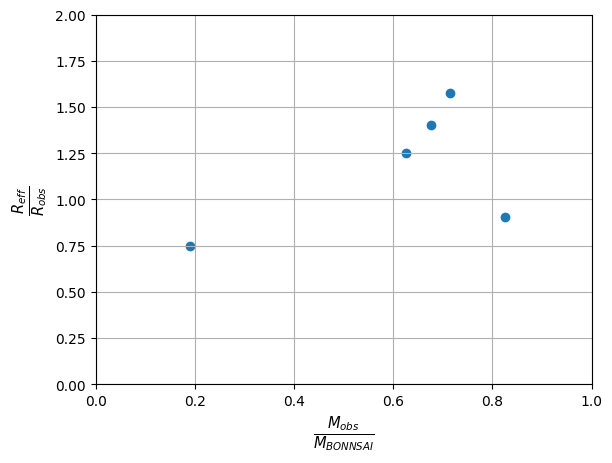

In [24]:
plt.scatter(df_M["M_opt/M_exp"], df_R_filtered["R_expected/R_true"])
plt.ylim(0,2)
plt.xlim(0,1)
plt.grid(True)
plt.xlabel(r"$\frac{M_{obs}}{M_{BONNSAI}}$", fontsize=15)
plt.ylabel(r"$\frac{R_{eff}}{R_{obs}}$", fontsize=15)
plt.show()